O2 Requirement Prediction Accuracy: 0.6923076923076923
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       0.56      0.93      0.70        15
         1.0       0.93      0.54      0.68        24

    accuracy                           0.69        39
   macro avg       0.74      0.74      0.69        39
weighted avg       0.79      0.69      0.69        39



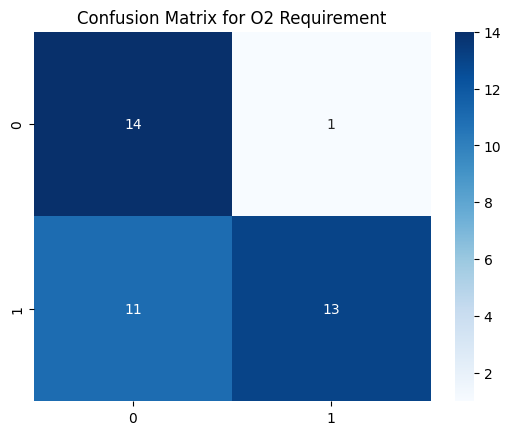

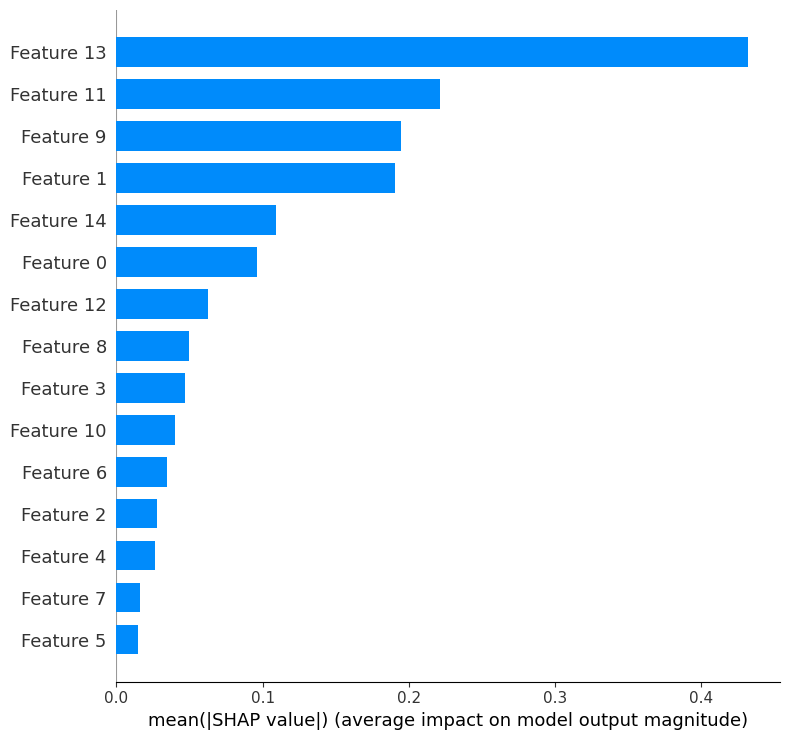

Top important features based on SHAP values:
['A0A0B4J1X5' 'A0A0B4J1V0' 'A0A0A0MS15' 'A0A075B6I9' 'A0A0B4J1X8'
 'A0A075B6I0' 'A0A0B4J1V2' 'A0A0A0MS14' 'A0A075B6R2' 'A0A0B4J1U7']


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import shap
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Step 1: Load and Preprocess Data
imputed_data = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/imputed_data.csv')
normalized_metadata = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/normalised_metadata_key_features.csv')

# Strip any whitespace from column names in the normalized metadata
normalized_metadata.columns = normalized_metadata.columns.str.strip()

# Exclude the 'Sample' column from imputed_data
if 'Sample' in imputed_data.columns:
    imputed_data = imputed_data.drop(columns=['Sample'])

# Join the datasets (keeping 'Sample' in normalized_metadata if needed)
combined_data = imputed_data.join(normalized_metadata[['O2 req.']], how='inner')

# Encode categorical variables if any exist in the combined dataset
label_encoder = LabelEncoder()
for column in combined_data.columns:
    if combined_data[column].dtype == 'object':
        combined_data[column] = label_encoder.fit_transform(combined_data[column].astype(str))

# Impute missing values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data), columns=combined_data.columns)

# Step 2: Prepare Dataset for O2 Requirement Prediction
X = combined_data_imputed.drop(columns=['O2 req.'])

# Ensure the 'Sample' column is completely removed
if 'Sample' in X.columns:
    X = X.drop(columns=['Sample'])

y = combined_data_imputed['O2 req.']

# Step 3: Initial Model Training and SHAP Analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Feature Selection with RFE
model_xgb = XGBClassifier(random_state=42)
rfe = RFE(estimator=model_xgb, n_features_to_select=15)  # Select top 15 features
X_resampled_rfe = rfe.fit_transform(X_resampled, y_resampled)
X_test_rfe = rfe.transform(X_test)

# Hyperparameter Tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = RandomizedSearchCV(model_xgb, param_grid, cv=5, n_jobs=-1, scoring='accuracy', n_iter=50)
grid_search.fit(X_resampled_rfe, y_resampled)

best_model = grid_search.best_estimator_

# Evaluate the Model
y_pred = best_model.predict(X_test_rfe)
print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()

# SHAP Values for Feature Importance
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_rfe)
shap.summary_plot(shap_values, X_test_rfe, plot_type="bar")

# Get the mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Get feature names in descending order of importance
important_features = np.array(X.columns)[np.argsort(shap_importance)[::-1]]

print("Top important features based on SHAP values:")
print(important_features[:10])  # Show top 10 features


Implenting changes

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Select the top features
top_features = ['A0A0B4J1X5', 'A0A0B4J1V0', 'A0A0A0MS15', 'A0A075B6I9', 'A0A0B4J1X8',
 'A0A075B6I0', 'A0A0B4J1V2', 'A0A0A0MS14', 'A0A075B6R2', 'A0A0B4J1U7']

# Apply Polynomial Features to the top features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[top_features])

# Add interaction terms back to the data
X_combined = pd.concat([pd.DataFrame(X_poly, columns=poly.get_feature_names_out(top_features)), X.reset_index(drop=True)], axis=1)




O2 Requirement Prediction Accuracy: 0.5384615384615384
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       0.43      0.60      0.50        15
         1.0       0.67      0.50      0.57        24

    accuracy                           0.54        39
   macro avg       0.55      0.55      0.54        39
weighted avg       0.58      0.54      0.54        39



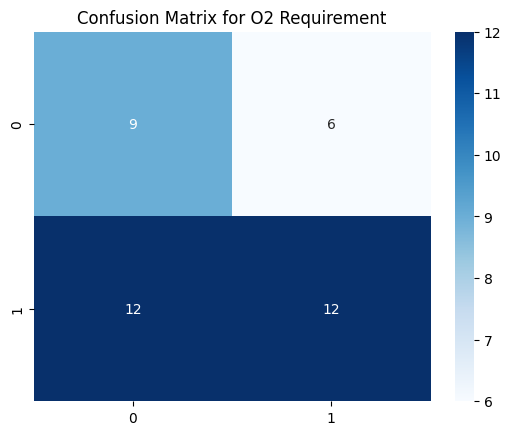

In [5]:
# Ensure the data is numeric and convert to NumPy array
X_resampled_np = X_resampled.values  # Convert to NumPy array
y_resampled_np = y_resampled.values  # Convert to NumPy array
X_test_np = X_test.values  # Convert to NumPy array

# Define and train the XGBoost model
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_resampled_np, y_resampled_np)

# Predictions and evaluation
y_pred = model_xgb.predict(X_test_np)

# Continue with the evaluation as before
print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()


Further improvement

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

In [7]:
#Load and Preprocess Data
imputed_data = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/imputed_data.csv')
normalized_metadata = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/normalised_metadata_key_features.csv')
# Strip any whitespace from column names in the normalized metadata
normalized_metadata.columns = normalized_metadata.columns.str.strip()

# Exclude the 'Sample' column from imputed_data
if 'Sample' in imputed_data.columns:
    imputed_data = imputed_data.drop(columns=['Sample'])

# Join the datasets (keeping 'Sample' in normalized_metadata if needed)
combined_data = imputed_data.join(normalized_metadata[['O2 req.']], how='inner')


In [8]:
# Step 4: Encode Categorical Variables Before Imputation
label_encoder = LabelEncoder()
for column in combined_data.columns:
    if combined_data[column].dtype == 'object':
        combined_data[column] = label_encoder.fit_transform(combined_data[column].astype(str))

# Verify that all columns are numeric
print("Data types after encoding:")
print(combined_data.dtypes)


Data types after encoding:
A0A075B6I0                                      float64
A0A075B6I9                                      float64
A0A075B6K5                                      float64
A0A075B6R2                                      float64
A0A075B6S6                                      float64
                                                 ...   
Time between pos covid test and first sample    float64
Weight (kg)                                     float64
Dates of repeat samples                           int64
Days_between                                      int64
O2 req.                                           int64
Length: 1193, dtype: object


In [9]:
# Impute missing values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data), columns=combined_data.columns)

# Prepare Dataset for O2 Requirement Prediction
X = combined_data_imputed.drop(columns=['O2 req.'])

# Ensure the 'Sample' column is completely removed
if 'Sample' in X.columns:
    X = X.drop(columns=['Sample'])

y = combined_data_imputed['O2 req.']



In [10]:


# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Step 8: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 9: Define the Pipeline with Scaling and XGBoost Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, n_estimators=50))  # Reduced n_estimators for faster computation
])

In [12]:
# Step 10: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=50,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [13]:
# Step 11: Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

O2 Requirement Prediction Accuracy: 0.5897435897435898
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       0.48      0.67      0.56        15
         1.0       0.72      0.54      0.62        24

    accuracy                           0.59        39
   macro avg       0.60      0.60      0.59        39
weighted avg       0.63      0.59      0.59        39



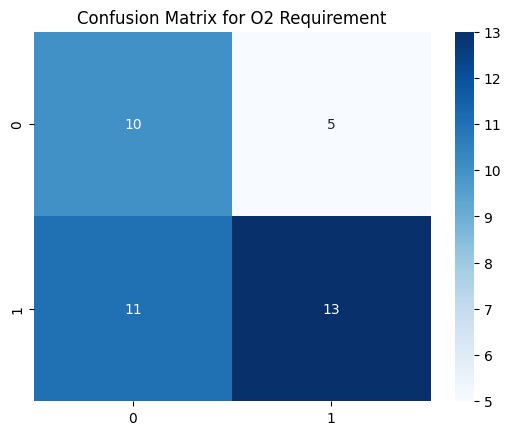

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()

In [15]:
# Step 12: Cross-validation Scores
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores for O2 requirement model:", cv_scores)
print("Mean CV Score for O2 requirement:", cv_scores.mean())

Cross-validation scores for O2 requirement model: [0.66666667 0.46153846 0.38461538 0.47368421 0.57894737]
Mean CV Score for O2 requirement: 0.5130904183535762


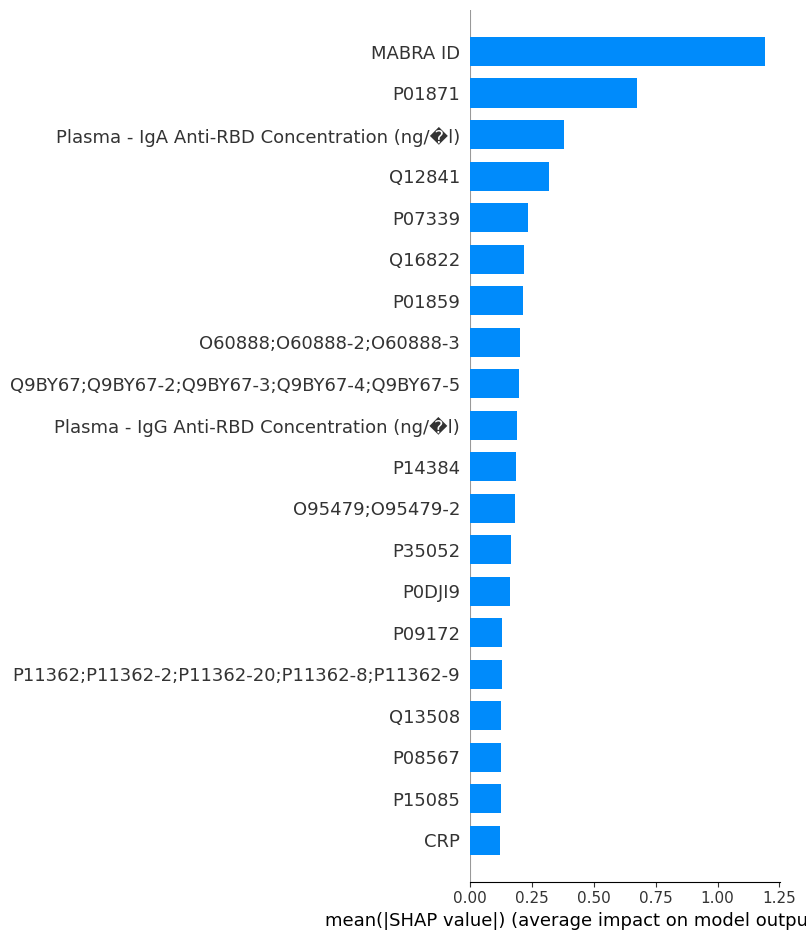

In [16]:
# Step 13: SHAP Values for Feature Importance
explainer = shap.Explainer(best_model['xgb'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

Further tuning

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#Load and Preprocess Data
imputed_data = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/imputed_data.csv')
normalized_metadata = pd.read_csv('C:/Users/saiya/OneDrive/Desktop/Project/normalised_metadata_key_features.csv')

# Strip any whitespace from column names in the normalized metadata
normalized_metadata.columns = normalized_metadata.columns.str.strip()

# Exclude the 'Sample' column from imputed_data
if 'Sample' in imputed_data.columns:
    imputed_data = imputed_data.drop(columns=['Sample'])

# Join the datasets (keeping 'Sample' in normalized_metadata if needed)
combined_data = imputed_data.join(normalized_metadata[['O2 req.']], how='inner')

In [19]:
# Step 4: Encode Categorical Variables Before Imputation
label_encoder = LabelEncoder()
for column in combined_data.columns:
    if combined_data[column].dtype == 'object':
        combined_data[column] = label_encoder.fit_transform(combined_data[column].astype(str))

# Verify that all columns are numeric
print("Data types after encoding:")
print(combined_data.dtypes)

Data types after encoding:
A0A075B6I0                                      float64
A0A075B6I9                                      float64
A0A075B6K5                                      float64
A0A075B6R2                                      float64
A0A075B6S6                                      float64
                                                 ...   
Time between pos covid test and first sample    float64
Weight (kg)                                     float64
Dates of repeat samples                           int64
Days_between                                      int64
O2 req.                                           int64
Length: 1193, dtype: object


In [22]:
# Impute missing values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data), columns=combined_data.columns)

# Prepare Dataset for O2 Requirement Prediction
X = combined_data_imputed.drop(columns=['O2 req.'])

# Ensure the 'Sample' column is completely removed
if 'Sample' in X.columns:
    X = X.drop(columns=['Sample'])

y = combined_data_imputed['O2 req.']


In [23]:
# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Feature Engineering with PolynomialFeatures based on SHAP values
top_features = [
    'MABRA ID',
    'P01871', 
    'Plasma - IgA Anti-RBD Concentration (ng/�l)', 
    'Q12841', 
    'P07339', 
    'Q16822', 
    'P01859'
] # Add more features if needed

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_train[top_features])

# Add interaction terms back to the data
X_train_poly = pd.concat([pd.DataFrame(X_poly, columns=poly.get_feature_names_out(top_features)), X_train.reset_index(drop=True)], axis=1)

In [24]:
# Step 9: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_poly, y_train)

In [25]:
# Step 10: Define the Pipeline with Scaling and XGBoost Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

In [26]:
# Step 11: Hyperparameter Tuning using RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipeline, param_grid, cv=strat_kfold, n_jobs=-1, scoring='accuracy', random_state=42)
search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feat...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.8, 1.0],
                                        'xgb__learning_rate': [0.01, 0.1, 0.2],
                                        'xgb__max_depth': [3, 5, 7],
                                        'xgb__n_estimators': [100, 200, 300],
                                        'xgb__subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [27]:
# Generate interaction terms for the test set based on the selected features
X_test_poly = poly.transform(X_test[top_features])

# Combine the interaction terms with the original test set features
X_test_combined = pd.concat([pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(top_features)), X_test.reset_index(drop=True)], axis=1)

O2 Requirement Prediction Accuracy: 0.6153846153846154
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57        15
         1.0       0.74      0.58      0.65        24

    accuracy                           0.62        39
   macro avg       0.62      0.62      0.61        39
weighted avg       0.65      0.62      0.62        39



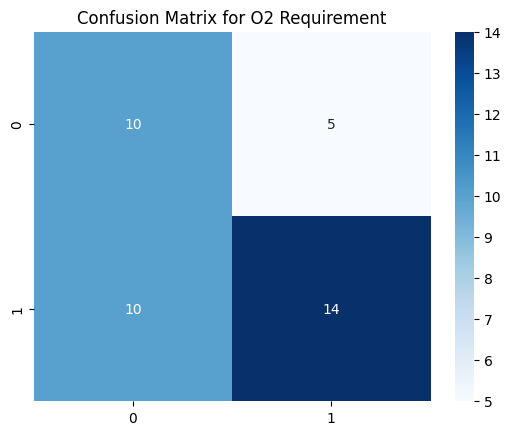

In [28]:
# Step 12: Evaluate on the test set with the combined features
y_pred = search.best_estimator_.predict(X_test_combined)

print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()

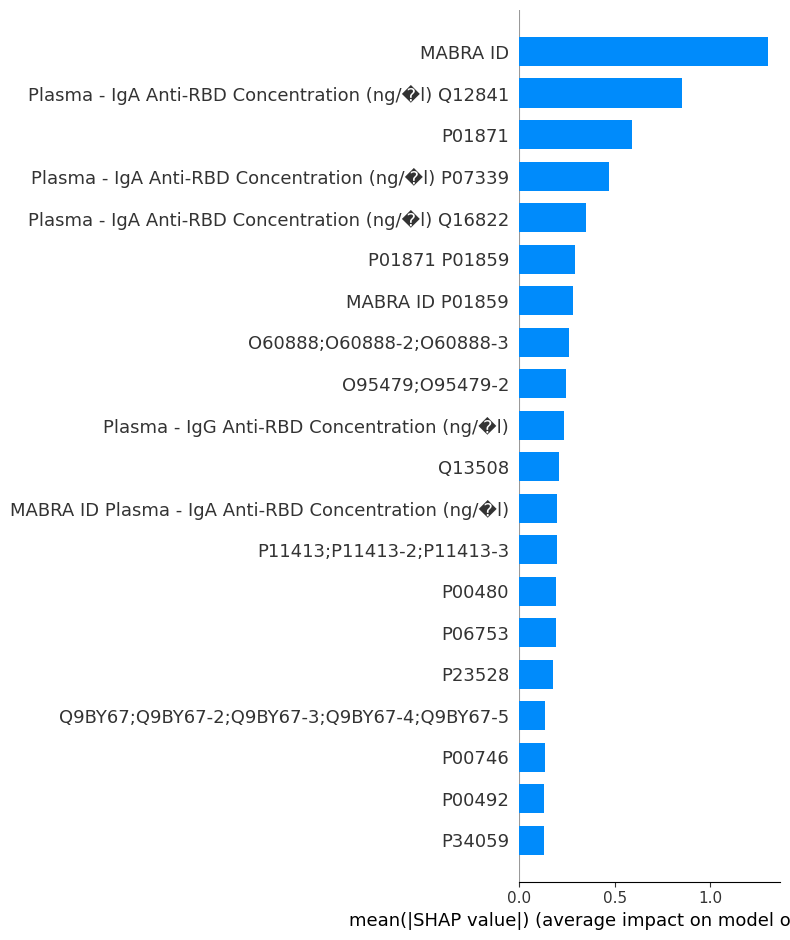

In [29]:
# Step 13: SHAP Values for Feature Importance

# Ensure that the DataFrame is in the correct format
X_test_combined_np = X_test_combined.to_numpy()

# Explainer should be created using the final model directly, no need to access via 'xgb' in the pipeline
explainer = shap.Explainer(search.best_estimator_.named_steps['xgb'])

# Calculate SHAP values using the transformed numpy array
shap_values = explainer(X_test_combined_np)

# Convert SHAP values back to a DataFrame for compatibility with plotting
shap.summary_plot(shap_values, X_test_combined, plot_type="bar")

In [30]:
# Step 14: Cross-validation Scores
cv_scores = cross_val_score(search.best_estimator_, X_resampled, y_resampled, cv=strat_kfold)
print("Cross-validation scores for O2 requirement model:", cv_scores)
print("Mean CV Score for O2 requirement:", cv_scores.mean())

Cross-validation scores for O2 requirement model: [0.5625  0.625   0.71875 0.65625 0.65625]
Mean CV Score for O2 requirement: 0.64375


More tuning

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [32]:
# Assuming X and y are your original datasets

# Step 1: Align X and y by removing rows where y has missing values
valid_indices = y.dropna().index
X_aligned = X.loc[valid_indices].reset_index(drop=True)
y_aligned = y.loc[valid_indices].reset_index(drop=True)

# Check shape consistency
print("Before imputation:")
print(f"X_aligned shape: {X_aligned.shape}")
print(f"y_aligned shape: {y_aligned.shape}")

Before imputation:
X_aligned shape: (193, 1192)
y_aligned shape: (193,)


In [33]:
# Step 2: Define a Pipeline with Imputation, Scaling, and XGBoost
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

# Step 3: Apply SMOTE for imbalanced dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_aligned, y_aligned)

In [34]:
# Step 4: Perform cross-validation with fewer splits
strat_shufflesplit = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
cv_scores = cross_val_score(pipeline, X_resampled, y_resampled, cv=strat_shufflesplit, scoring='accuracy')

# Output the cross-validation results
print("Cross-validation scores for O2 requirement model:", cv_scores)
print("Mean CV Score for O2 requirement:", cv_scores.mean())

Cross-validation scores for O2 requirement model: [0.61904762 0.63492063 0.55555556]
Mean CV Score for O2 requirement: 0.6031746031746031


In [35]:
# Step 5: Train the model on the entire resampled dataset
pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [36]:
# Step 6: Evaluate on the test set (assuming X_test and y_test are defined)
y_pred = pipeline.predict(X_test)
print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

O2 Requirement Prediction Accuracy: 1.0
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        24

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



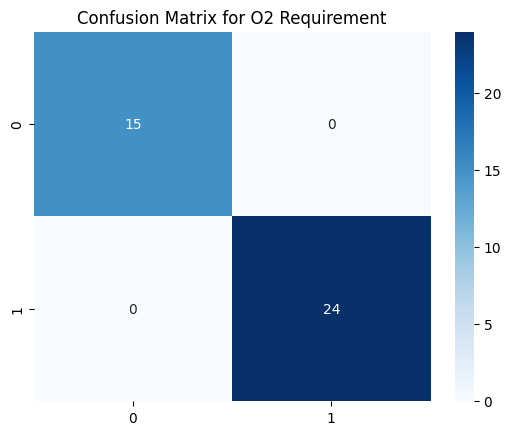

In [37]:
# Step 7: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()


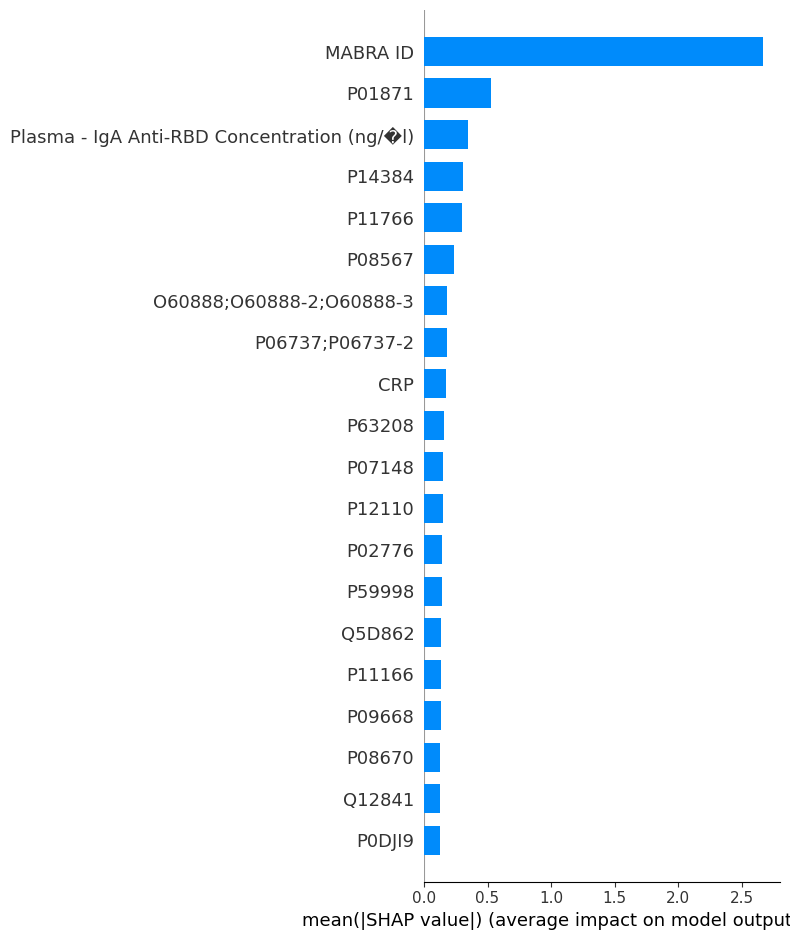

In [38]:
# Step 8: SHAP values for feature importance
explainer = shap.Explainer(pipeline.named_steps['xgb'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

with regularization and feature selection

Cross-validation scores for O2 requirement model: [0.66666667 0.73809524 0.5952381  0.73170732 0.73170732]
Mean CV Score for O2 requirement: 0.6926829268292682
O2 Requirement Prediction Accuracy: 0.9230769230769231
Classification Report for O2 Requirement:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        15
         1.0       0.96      0.92      0.94        24

    accuracy                           0.92        39
   macro avg       0.92      0.93      0.92        39
weighted avg       0.93      0.92      0.92        39



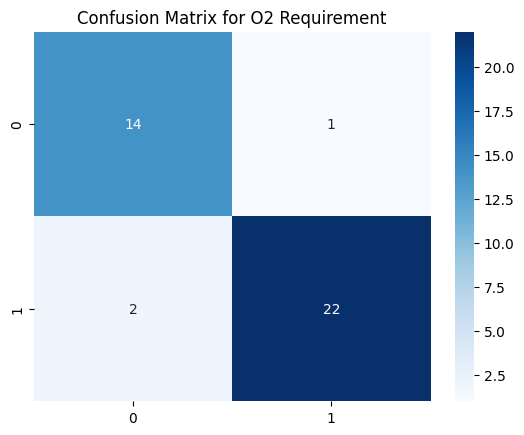

In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Feature selection using SHAP values
model_shap = SelectFromModel(estimator=XGBClassifier(random_state=42))
X_selected = model_shap.fit_transform(X_resampled, y_resampled)

# Define the pipeline with regularization
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l2', C=0.1, random_state=42))  # Example of regularization
])

# Perform cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_selected, y_resampled, cv=strat_kfold, scoring='accuracy')

# Output the cross-validation results
print("Cross-validation scores for O2 requirement model:", cv_scores)
print("Mean CV Score for O2 requirement:", cv_scores.mean())

# Train the model on the entire resampled dataset
pipeline.fit(X_selected, y_resampled)

# Evaluate on the test set (assuming X_test and y_test are defined)
X_test_selected = model_shap.transform(X_test)
y_pred = pipeline.predict(X_test_selected)
print("O2 Requirement Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report for O2 Requirement:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for O2 Requirement')
plt.show()




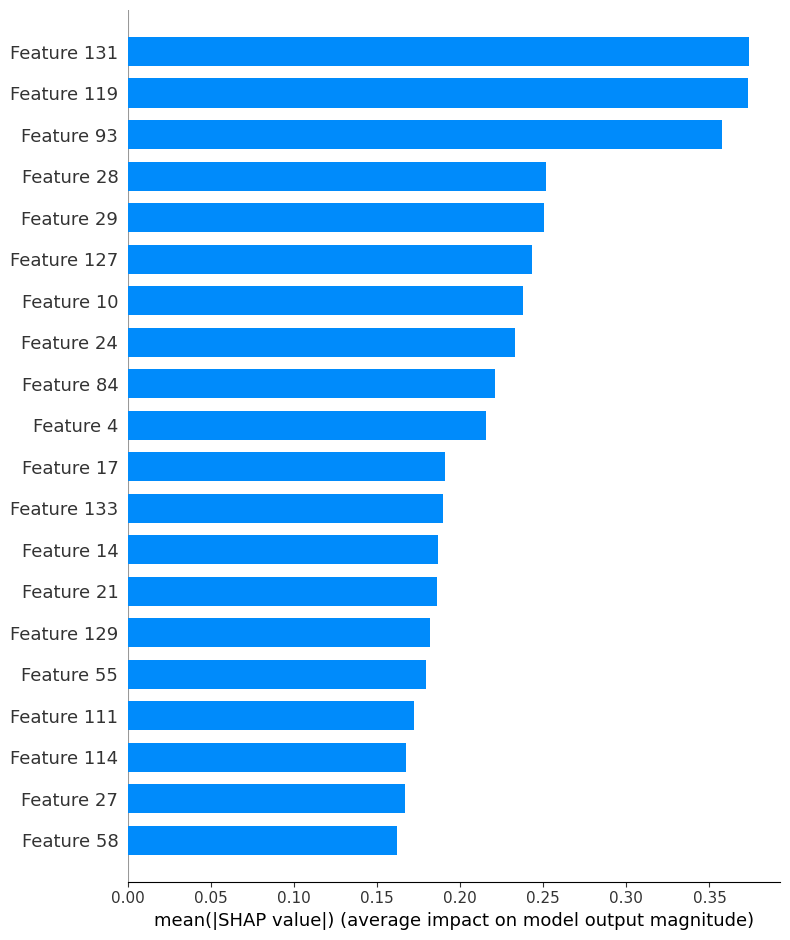

In [40]:
import shap

# Step 1: Use the pipeline to transform the training data
X_train_transformed = pipeline.named_steps['scaler'].transform(X_selected)

# Step 2: Also ensure the test data goes through the same feature selection process
X_test_transformed = pipeline.named_steps['scaler'].transform(X_test_selected)

# Step 3: SHAP values for feature importance with LinearExplainer
explainer = shap.LinearExplainer(pipeline.named_steps['classifier'], X_train_transformed)
shap_values = explainer.shap_values(X_test_transformed)

# Step 4: Plot the SHAP summary
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")


In [50]:
# Identify Feature 131 in the imputed_data
if len(imputed_data.columns) > 130:
    feature_131_imputed = imputed_data.columns[130]
    print(f"Feature 131 in imputed_data: {feature_131_imputed}")
else:
    print("Feature 131 is not in imputed_data.")

# Identify Feature 131 in the normalized_metadata
if len(normalized_metadata.columns) > 130:
    feature_131_metadata = normalized_metadata.columns[130]
    print(f"Feature 131 in normalized_metadata: {feature_131_metadata}")
else:
    print("Feature 131 is not in normalized_metadata.")


Feature 131 in imputed_data: P00748
Feature 131 is not in normalized_metadata.


P00748 is the biomarker

Learning curve

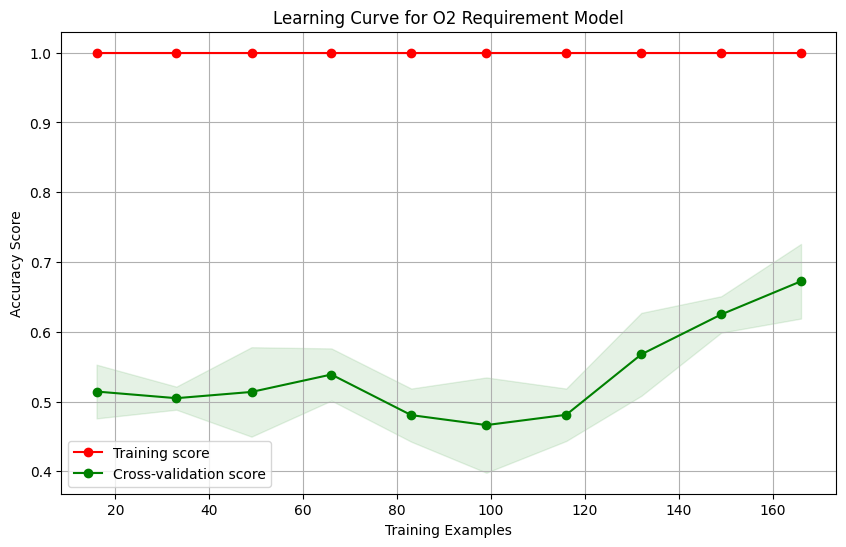

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

# Define the cross-validation strategy
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=search.best_estimator_,  # Use the best model from your RandomizedSearchCV
    X=X_resampled,  # Use your resampled data
    y=y_resampled,
    cv=strat_kfold,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced intervals
    random_state=42
)

# Calculate the mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# Fill the area between the curves to indicate standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title('Learning Curve for O2 Requirement Model')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.legend(loc="best")
plt.grid()
plt.show()
